# Modèle XGBOOST

In [1]:
# Import libraries and modules

# Import the necessary libraries
import sys
import os

# Add the project directory to the sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import everything from lib_import.py, data_exploring.py, data_preprocessing.py 
from lib.lib_import import *
from src.data_preprocessing import *
from src.model_evaluation import *
from src.model_training import *

# Import the data
from data.data_extract import load_data
import optuna

Everything imported successfully.


In [2]:
# XGBoost
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

## Extraction

In [3]:
# Load the data

df_data = load_data()
df_data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Prétraitement Générale

In [4]:
df = df_data.copy()
df = preprocess(df)
df.head(10)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>50K
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp,83311,13,Married,Exec-managerial,Married,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Now Single,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married,Prof-specialty,Married,Black,Female,0,0,40,Other,0
5,37,Private,284582,14,Married,Exec-managerial,Married,White,Female,0,0,40,United-States,0
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Other,0
7,52,Self-emp,209642,9,Married,Exec-managerial,Married,White,Male,0,0,45,United-States,1
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,13,Married,Exec-managerial,Married,White,Male,5178,0,40,United-States,1


In [5]:
cat_features = get_cat_features(df)
cont_features = get_cont_features(df)


In [6]:
df_train, df_test = seperate_train_test(df, random_state=42)
df_train,df_test =impute_missing_cat_values(df_train, df_test,cat_features,strategy='most_frequent')
df_train,df_test = standardize(df_train, df_test, cont_features)
df_train,df_test = encode_cat_features_onehot(df_train, df_test, cat_features)

In [7]:
df_train_select = df_train.drop('>50K', axis=1)
df_test_select = df_test.drop('>50K', axis=1)
target_train = df_train['>50K']
target_test = df_test['>50K']

In [8]:
X_train = df_train_select.values
X_test = df_test_select.values

y_train = df_train['>50K'].values
y_test = df_test['>50K'].values


In [9]:
def plot_confusion_matrix_sns(y_test, y_pred, model_name):
    """
    Affiche la matrice de confusion pour les prédictions d'un modèle.
    """

    print('='*30)
    print(model_name)
    print('='*30, '\n')

    print("Matrice de confusion:")
    c_matrix = confusion_matrix(y_test, y_pred)
    print(c_matrix, '\n') # afficher à l'écran notre matrice de confusion
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred), '\n')
    print('Exactitude: %f' %(accuracy_score(y_test, y_pred)*100), '\n')

    # Affichage et enregistrement de la matrice de confusion avec Seaborn
    plt.figure(figsize=(8, 4))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues',cbar_kws={'label': 'Count'})
    plt.title(f'{model_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    save_image(plt,model_name)


In [10]:
smt = SMOTE(random_state=7)

# Do the process
X_train_up, y_train_up = smt.fit_resample(X_train, y_train)

## XGBClassifier

### Test sans Hyperparametre

In [36]:
# Création et entraînement du modèle XGBoost
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
# Prédiction sur l'ensemble de test
y_pred = model_xgb.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8678


GradientBoosting

Matrice de confusion:
[[7001  421]
 [ 863 1424]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      7422
           1       0.77      0.62      0.69      2287

    accuracy                           0.87      9709
   macro avg       0.83      0.78      0.80      9709
weighted avg       0.86      0.87      0.86      9709
 

Exactitude: 86.775157 



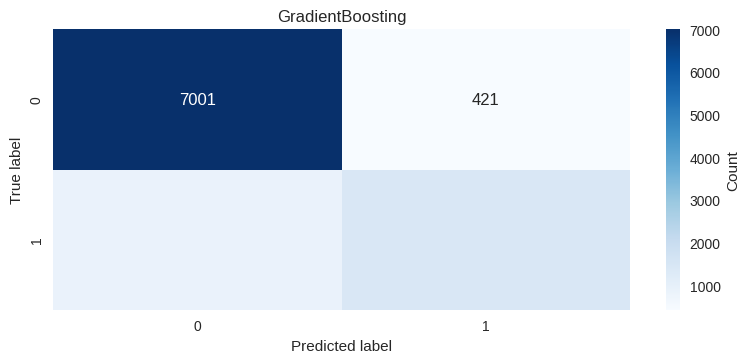

In [38]:
plot_confusion_matrix_sns(y_test, y_pred, "GradientBoosting")

In [39]:
def print_courbe_apprentissage(model, X_train_up, y_train_up, model_name,score): 
    N, train_score, val_score = learning_curve(model, X_train_up, y_train_up, 
                                           cv=5, scoring=score,
                                           train_sizes=np.linspace(0.1, 1, 10))

    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.title("Courbe d'apprentissage pour "+ model_name)
    

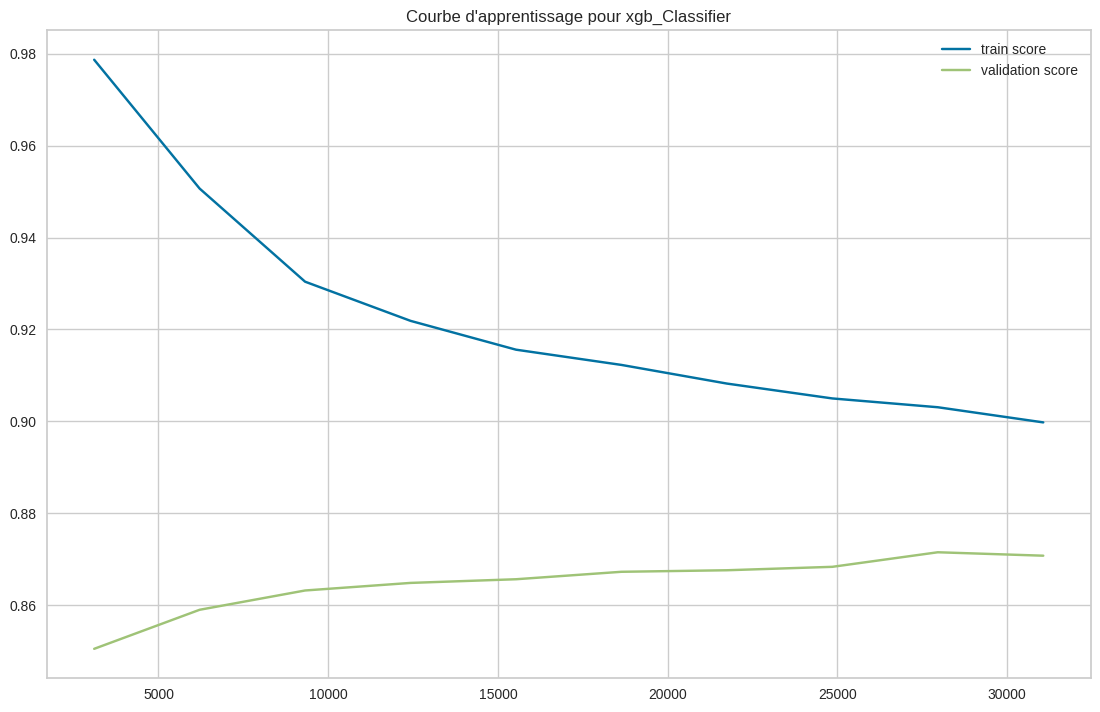

In [40]:
print_courbe_apprentissage(model_xgb, X_train, y_train,"xgb_Classifier" ,"f1_micro")

### Hyper-optimisation

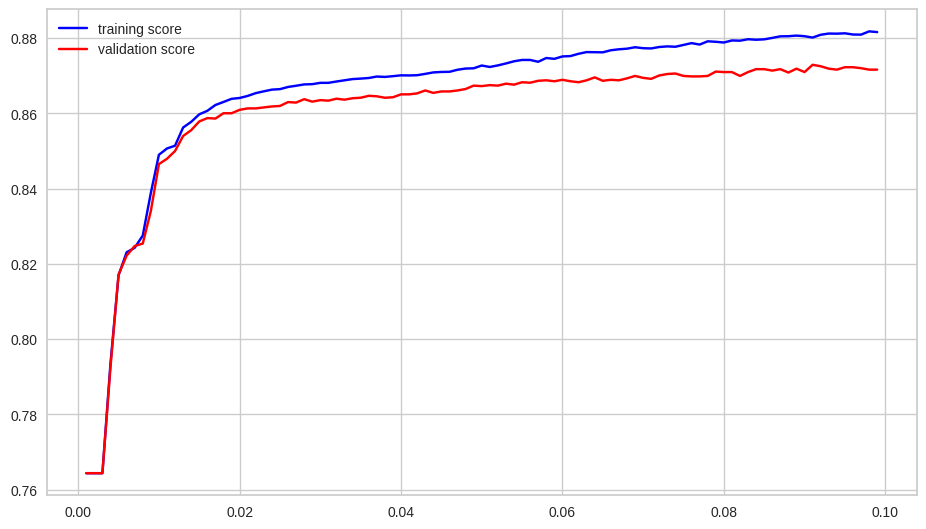

In [126]:
# plusieurs valeurs pour le paramètre learning_rate
model = xgb.XGBClassifier()
learning_rate = np.arange(0.001, 0.1, 0.001)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='learning_rate',
    param_range=learning_rate,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(learning_rate, np.median(train_score, 1), color='blue', label='training score')
plt.plot(learning_rate, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.show()

Nous remarquons qu'à partir du 0.01 , le modele est en sous apprentissage

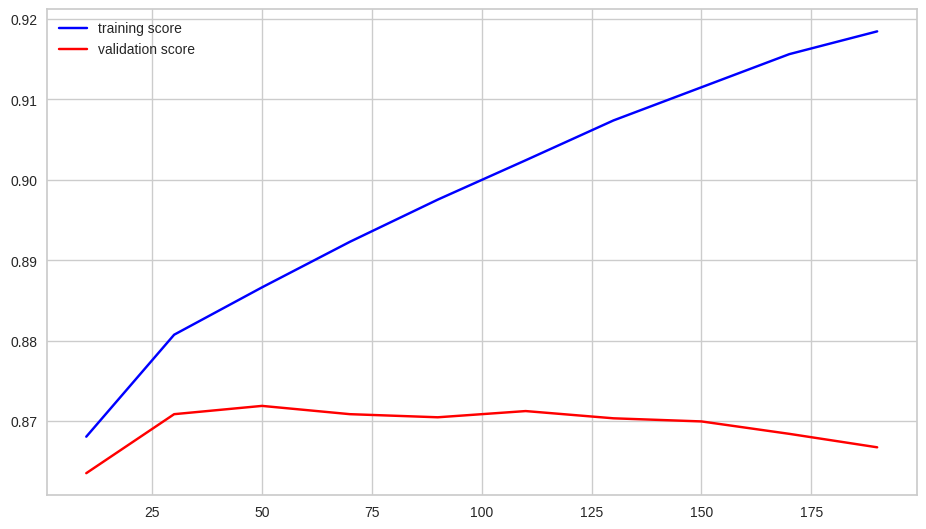

In [129]:
# plusieurs valeurs pour le paramètre n_estimators
model = xgb.XGBClassifier()
n_estimators = np.arange(1, 10, 20)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='n_estimators',
    param_range=n_estimators,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(n_estimators, np.median(train_score, 1), color='blue', label='training score')
plt.plot(n_estimators, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.show()

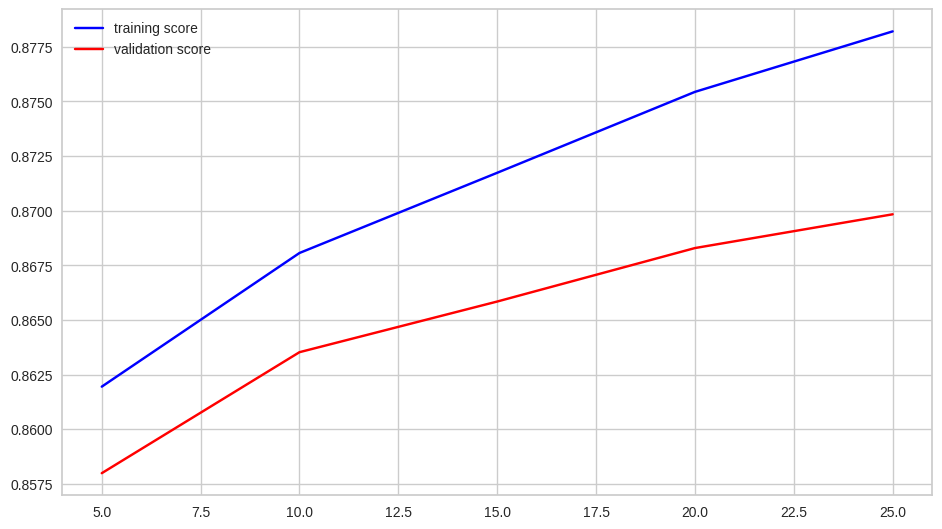

In [132]:
# plusieurs valeurs pour le paramètre n_estimators
model = xgb.XGBClassifier()
n_estimators = np.arange(5, 30, 5)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='n_estimators',
    param_range=n_estimators,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(n_estimators, np.median(train_score, 1), color='blue', label='training score')
plt.plot(n_estimators, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.show()

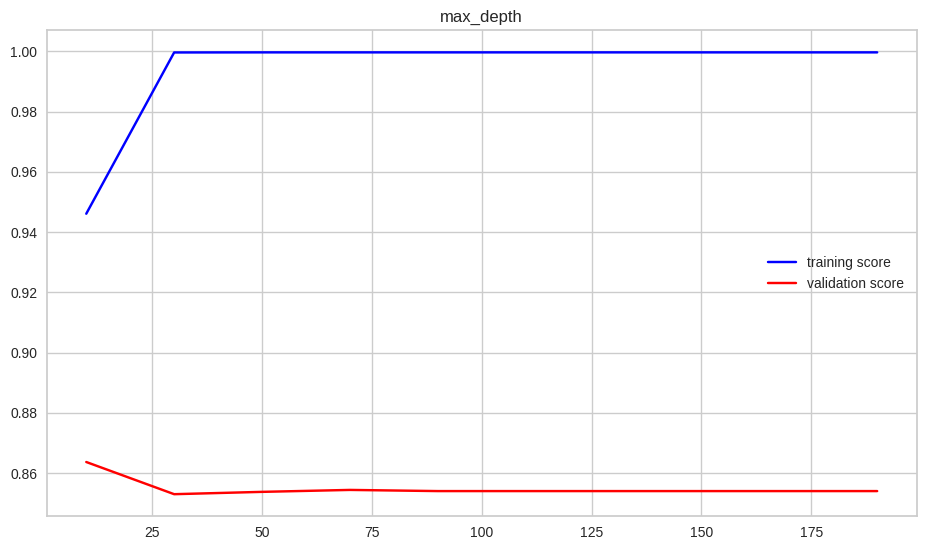

In [133]:
# plusieurs valeurs pour le paramètre max_depth
model = xgb.XGBClassifier()
max_depth = np.arange(10, 200, 20)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='max_depth',
    param_range=max_depth,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(max_depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(max_depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
# ajout titre au plt
plt.title("max_depth")
plt.show()

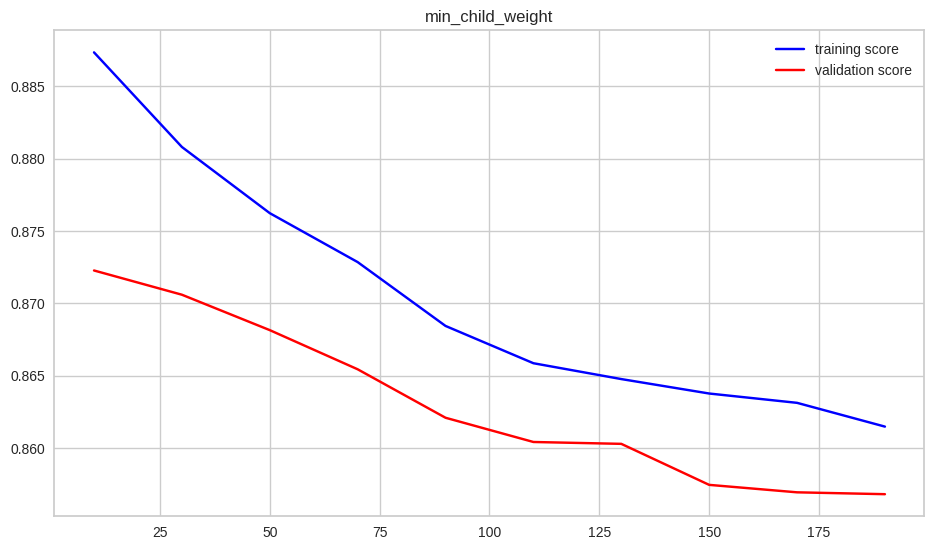

In [134]:
#min_child_weight
model = xgb.XGBClassifier()
min_depth = np.arange(10, 200, 20)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='min_child_weight',
    param_range=min_depth,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(min_depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(min_depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.title("min_child_weight")
plt.show()

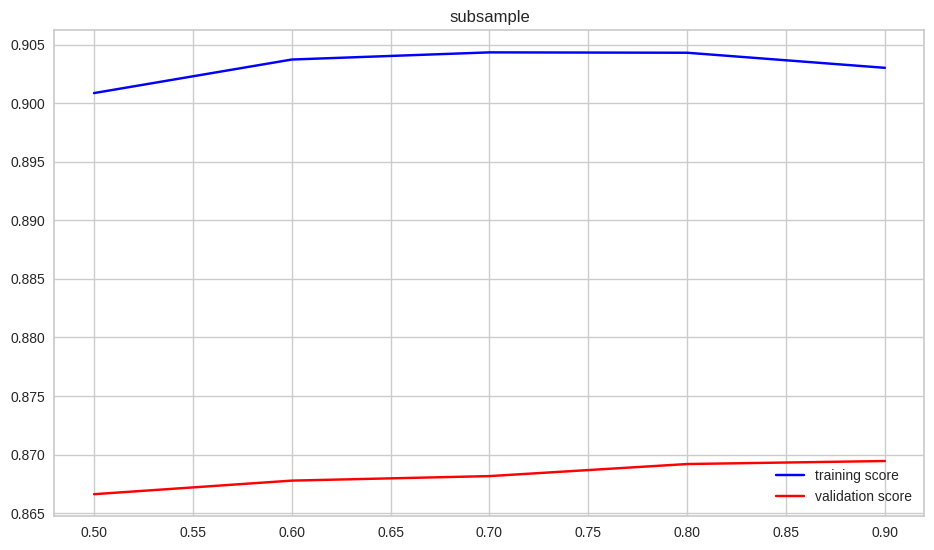

In [136]:
#min_child_weight
model = xgb.XGBClassifier()
subsample = np.arange(0.5, 1.0,0.1)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='subsample',
    param_range=subsample,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(subsample, np.median(train_score, 1), color='blue', label='training score')
plt.plot(subsample, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.title("subsample")
plt.show()

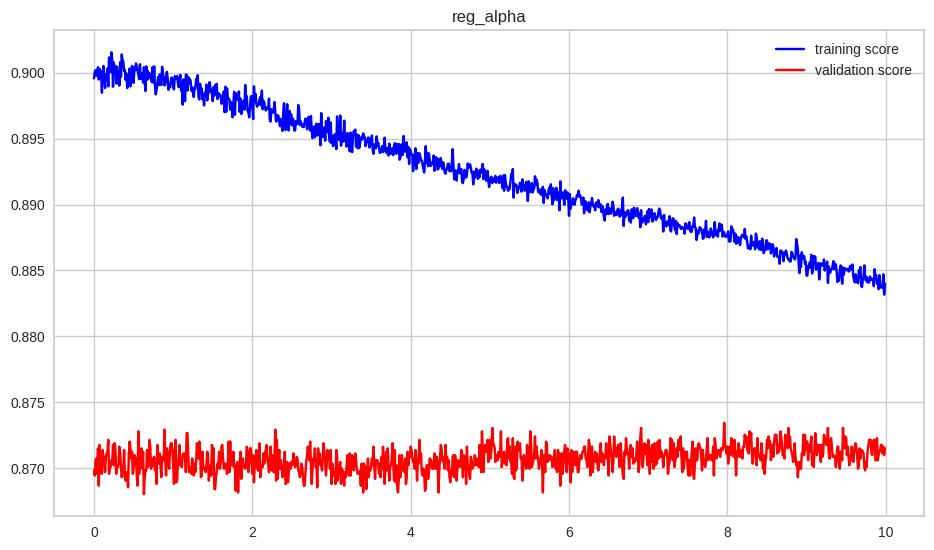

In [11]:
#reg_alpha
model = xgb.XGBClassifier()
reg_alpha = np.arange(01e-4, 1e1,0.01)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='reg_alpha',
    param_range=reg_alpha,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(reg_alpha, np.median(train_score, 1), color='blue', label='training score')
plt.plot(reg_alpha, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.title("reg_alpha")
plt.show()

En augmentant les valeurs de pénalité L1, l'ecart entre les scores diminue.

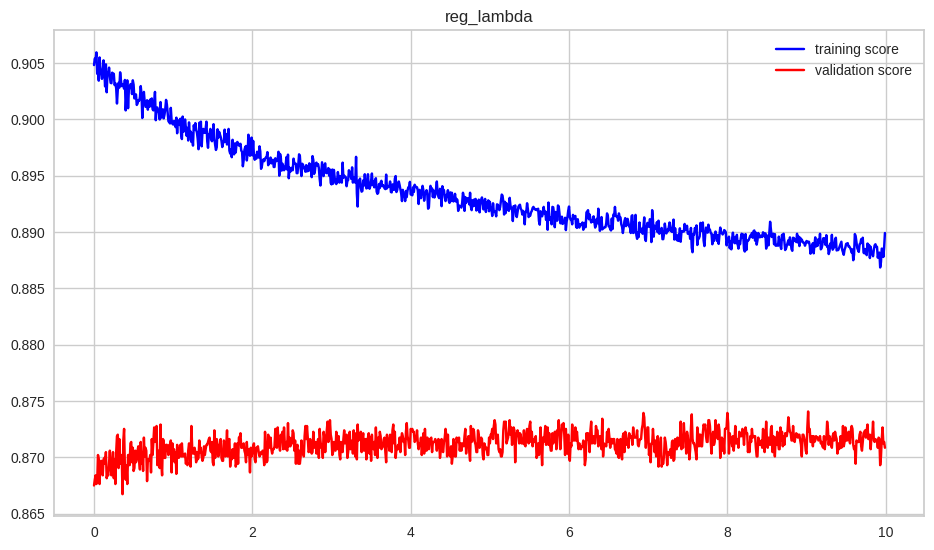

In [12]:
#reg_lambda
model = xgb.XGBClassifier()
reg_lambda = np.arange(01e-4, 1e1,0.01)
train_score, val_score = validation_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    param_name='reg_lambda',
    param_range=reg_alpha,
    cv=5,
    scoring='f1_micro'
)

plt.figure(figsize=(10,6))
plt.plot(reg_lambda, np.median(train_score, 1), color='blue', label='training score')
plt.plot(reg_lambda, np.median(val_score, 1), color='red', label='validation score')
plt.legend()
plt.title("reg_lambda")
plt.show()

In [89]:
def objective(trial):
    # Définir les hyperparamètres à optimiser
    params = { 
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), #Nombre d'arbres de décision à construire.
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1), #Taux d'apprentissage
        'max_depth': trial.suggest_int('max_depth', 3, 10), #Profondeur maximale de l'arbre
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Poids minimum d'un enfant
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0), # Sous-échantillonnage de l'ensemble de données
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),# Sous-échantillonnage des colonnes lors de la construction de chaque arbre
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e-1), # Réduction minimale de la fonction de perte requise pour effectuer une partition supplémentaire sur un nœud feuille de l'arbre
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1), # Pénalité L1 sur les poids
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1) # Pénalité L2 sur les poids
    }

    #model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
    # Pipeline pour le modèle
    model_xgb = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='auc',
            **params
        )

    # Utiliser la validation croisée pour évaluer le modèle
    score = cross_val_score(model_xgb, df_train_select, y_train, cv=5, scoring='f1_micro').mean()
    return score

In [90]:
# Étude Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Afficher les meilleurs hyperparamètres trouvés
print('Best hyperparameters: ', study.best_params)

[I 2024-06-15 09:13:15,532] A new study created in memory with name: no-name-a531516d-7b93-40fd-a282-d16d8d93d852
[I 2024-06-15 09:13:16,627] Trial 0 finished with value: 0.764387794515257 and parameters: {'n_estimators': 62, 'learning_rate': 0.0007361535624707155, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9833985395692696, 'colsample_bytree': 0.7529504970232583, 'gamma': 0.035655370663254214, 'reg_alpha': 0.0269055732657153, 'reg_lambda': 0.03222550965503229}. Best is trial 0 with value: 0.764387794515257.
[I 2024-06-15 09:13:19,479] Trial 1 finished with value: 0.764387794515257 and parameters: {'n_estimators': 89, 'learning_rate': 0.0006672003459221578, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.5623059551451977, 'colsample_bytree': 0.682127210476333, 'gamma': 0.0016372704646061594, 'reg_alpha': 0.0006732961349303849, 'reg_lambda': 0.5515492725094696}. Best is trial 0 with value: 0.764387794515257.
[I 2024-06-15 09:13:23,346] Trial 2 finished with value: 0.850

Best hyperparameters:  {'n_estimators': 146, 'learning_rate': 0.05630909832722768, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7649268997250023, 'colsample_bytree': 0.5700627731945481, 'gamma': 0.06474028601992628, 'reg_alpha': 0.10366481905839572, 'reg_lambda': 0.030056620941421027}


In [91]:
best_params = study.best_params
best_params

{'n_estimators': 146,
 'learning_rate': 0.05630909832722768,
 'max_depth': 9,
 'min_child_weight': 3,
 'subsample': 0.7649268997250023,
 'colsample_bytree': 0.5700627731945481,
 'gamma': 0.06474028601992628,
 'reg_alpha': 0.10366481905839572,
 'reg_lambda': 0.030056620941421027}

Best parametres : 
{'n_estimators': 146,
 'learning_rate': 0.05630909832722768,
 'max_depth': 9,
 'min_child_weight': 3,
 'subsample': 0.7649268997250023,
 'colsample_bytree': 0.5700627731945481,
 'gamma': 0.06474028601992628,
 'reg_alpha': 0.10366481905839572,
 'reg_lambda': 0.030056620941421027}

In [92]:
best_xgb = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
        **best_params
    )

# Entraîner le modèle sur l'ensemble d'entraînement complet
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5700627731945481, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.06474028601992628,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05630909832722768,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=146, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
# Prédiction sur l'ensemble de test
y_pred = best_xgb.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.8691935317746421

Best_XGBClassifier

Matrice de confusion:
[[7034  388]
 [ 882 1405]] 

Rapport de classification:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7422
           1       0.78      0.61      0.69      2287

    accuracy                           0.87      9709
   macro avg       0.84      0.78      0.80      9709
weighted avg       0.86      0.87      0.86      9709
 

Exactitude: 86.919353 



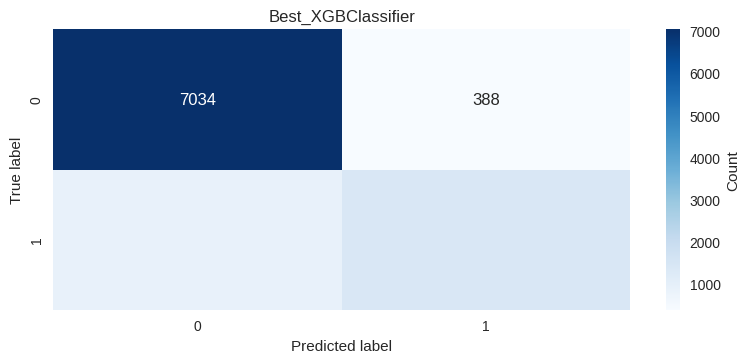

In [94]:
plot_confusion_matrix_sns(y_test, y_pred, "Best_XGBClassifier")

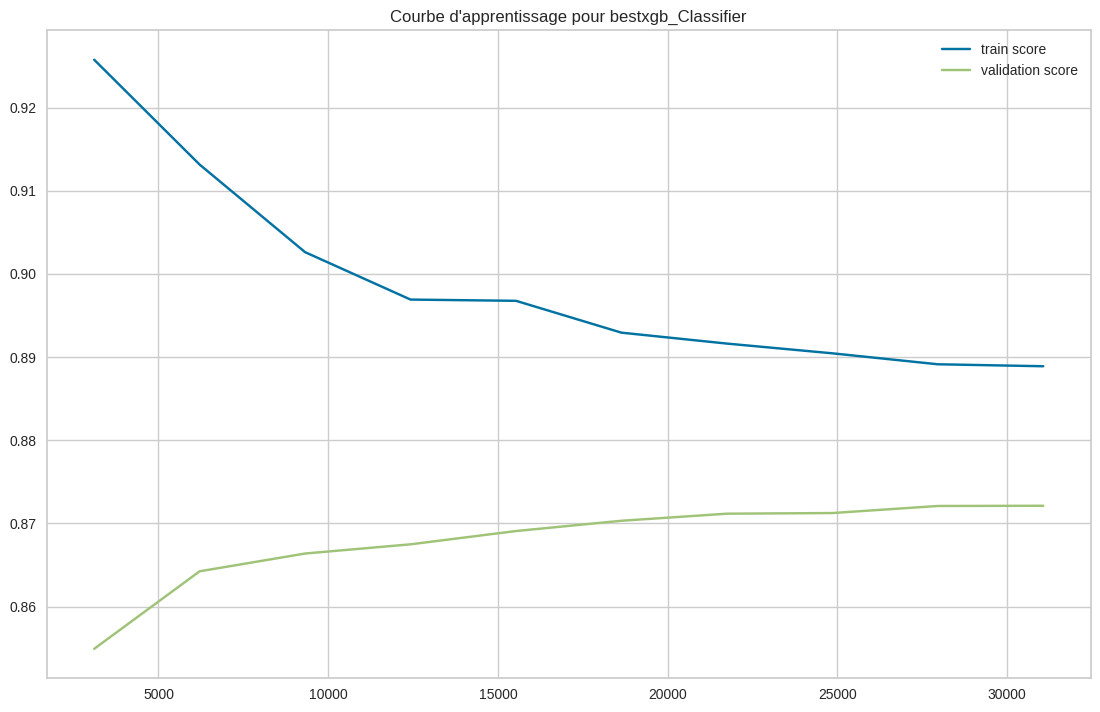

In [95]:
print_courbe_apprentissage(best_xgb, X_train, y_train, "bestxgb_Classifier","f1_micro")

L'ecart entre les deux score est très faible. Ce qui signifie qu'il ya pas de sur-apprentissage ni de sous apprentissage significatif

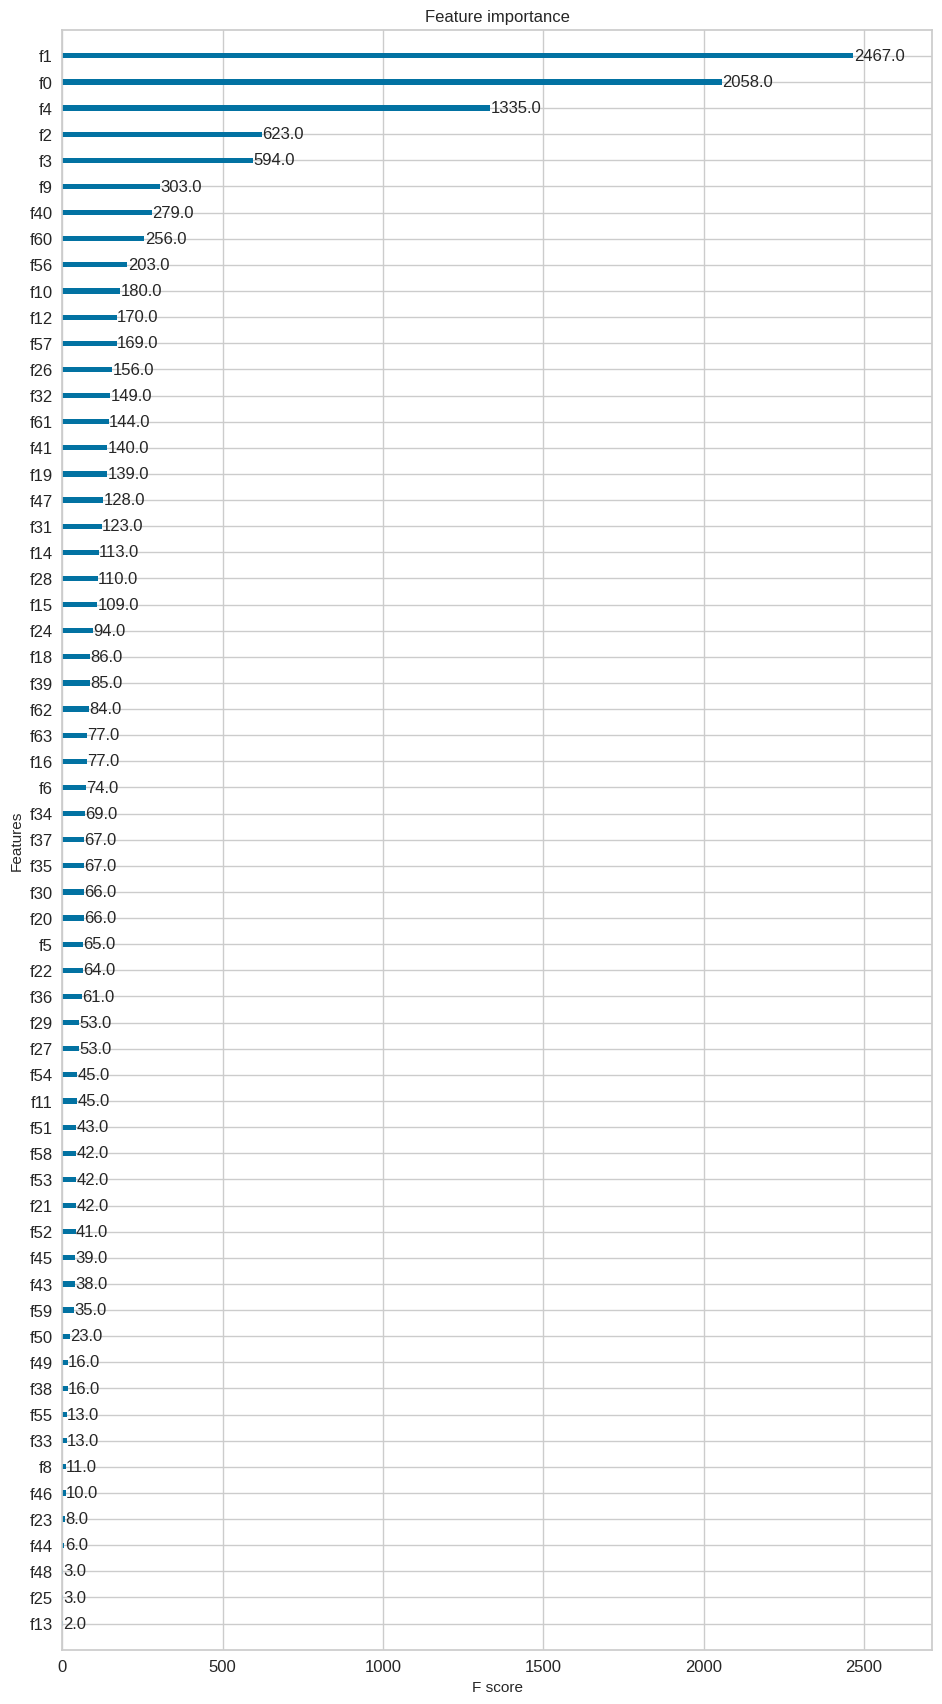

In [113]:

# Plot de l'importance des features
fig, ax = plt.subplots(figsize=(10, 20))  # Ajustez la taille de la figure selon vos besoins
xgb.plot_importance(best_xgb, ax=ax, importance_type='weight')

# Ajustez la taille de la police des labels et l'orientation
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

On remarque que très peu de features contribuent le plus aux décisions prises par le modèle. Il y a que 5 features qui sont les plus utilisés pour diviser les données dans tous les arbre